# **Análise e definição dos modelos**

Para que consigamos definir o melhor modelo a ser aplicado para a predição dos gastos, vamos testar as seguintes opções.

* Prophet
* AutoARIMA
* SeasonalNaive
* SeasonalWindowAverage

Posteriormente a isso, vamos utilizar métricas para validar qual é o melhor modelo de ML que se adequou aos nossos dados. O objetivo é uma taxa de assertividade maior que 75%.

Para esta validação inicial, utilizaremos São Paulo como parâmetro

### **Preparando o ambiente**

In [1]:
# Clonando o repositório para utilização neste notebook

!git clone https://github.com/iggorbrito/DataAnalysis.git

Cloning into 'DataAnalysis'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 225 (delta 25), reused 2 (delta 2), pack-reused 131
Receiving objects: 100% (225/225), 1.54 MiB | 4.72 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas - Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

# Biblioteca - AutoArima
!pip install pmdarima
from pmdarima import auto_arima

# Bibliotecas - Métricas
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             r2_score)
from sklearn.model_selection import TimeSeriesSplit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00


In [3]:
df = pd.read_csv('/content/DataAnalysis/hospitalar_production/docs/dados_tratados.csv')

df.head()

,Região/Unidade da Federação,2007/Ago,2007/Set,2007/Out,2007/Nov,2007/Dez,2008/Jan,2008/Fev,2008/Mar,2008/Abr,...,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,2023/Jul,2023/Ago
0,RO,4209.37,16397.03,133645.19,346912.84,711758.31,1829559.71,1940792.63,1955721.68,2143353.81,...,10172549.54,10171206.31,10740989.45,10016556.60,12293282.07,12219359.19,11890194.03,10665326.68,8605286.31,6663659.44
1,AC,10470.07,14001.71,86200.85,301323.68,769612.36,1731744.62,1743978.66,2057439.02,2057829.69,...,4029748.15,3956231.61,4031485.58,3681605.49,4621768.84,4396294.92,4782589.78,4942017.56,3825134.08,2036113.50
2,AM,35752.72,45570.64,416012.30,2020381.79,5949408.99,11419210.08,7934652.10,8641517.13,8531576.49,...,19430986.32,18254068.20,18240136.15,18092793.18,20887366.24,21078288.95,22816701.33,22253915.19,20493652.36,14405538.40
3,RR,4785.91,11858.63,43852.67,369328.51,470676.43,808448.39,771687.83,876091.18,896952.53,...,4672985.43,3837710.72,3970057.61,3568884.82,5034623.41,4214754.88,4264412.63,2728019.67,1679054.65,725887.92
4,PA,181159.29,433414.74,1893197.50,5105406.44,13162823.43,21762104.16,20126081.01,22149375.82,23436682.75,...,45952478.61,45055260.27,48234409.10,43513514.97,50938440.73,48148818.34,52211031.92,47777534.84,41483958.96,33968335.86


In [4]:
dados_sp = df[df['Região/Unidade da Federação'] == 'SP']

dados_sp.head()

,Região/Unidade da Federação,2007/Ago,2007/Set,2007/Out,2007/Nov,2007/Dez,2008/Jan,2008/Fev,2008/Mar,2008/Abr,...,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,2023/Jul,2023/Ago
19,SP,1665349.9,4434168.64,14577395.84,35032259.98,76668547.41,1.092388e+09,1.734509e+08,1.708386e+08,1.705658e+08,...,3.455710e+08,3.350481e+08,3.627515e+08,3.253564e+08,3.795817e+08,352252870.4,3.821908e+08,3.591735e+08,3.421268e+08,3.146695e+08


In [5]:
# Transpondo os dados para usar posteriormente
dados_sp_transpostos = dados_sp.T

dados_sp_transpostos.head()

,19
Região/Unidade da Federação,SP
2007/Ago,1665349.9
2007/Set,4434168.64
2007/Out,14577395.84
2007/Nov,35032259.98


In [6]:
dados_sp_transpostos.columns = dados_sp_transpostos.iloc[0]

# Removendo a segunda linha, que agora é redundante
dados_sp_transpostos = dados_sp_transpostos.iloc[1:]

In [7]:
dados_sp_transpostos.head()

Região/Unidade da Federação,SP
2007/Ago,1665349.9
2007/Set,4434168.64
2007/Out,14577395.84
2007/Nov,35032259.98
2007/Dez,76668547.41


In [8]:
dados_sp_transpostos = dados_sp_transpostos.rename_axis("mes/ano").rename(columns={dados_sp_transpostos.columns[0]: 'gastos_sp'})

dados_sp_transpostos.reset_index(inplace=True)

dados_sp_transpostos.head()

Região/Unidade da Federação,mes/ano,gastos_sp
0,2007/Ago,1665349.9
1,2007/Set,4434168.64
2,2007/Out,14577395.84
3,2007/Nov,35032259.98
4,2007/Dez,76668547.41


In [9]:
dados_sp_transpostos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   mes/ano    193 non-null    object
 1   gastos_sp  193 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


In [10]:
# Dicionário de mapeamento para os meses
mapa_meses = {
    'Jan': '01',
    'Fev': '02',
    'Mar': '03',
    'Abr': '04',
    'Mai': '05',
    'Jun': '06',
    'Jul': '07',
    'Ago': '08',
    'Set': '09',
    'Out': '10',
    'Nov': '11',
    'Dez': '12'
}

# Função para converter o formato do mês
def converter_mes(mes_ano):
    partes = mes_ano.split('/')
    mes_numero = mapa_meses[partes[1]]
    return f"{partes[0]}/{mes_numero}"

# Aplicando a função à coluna 'mes/ano'
dados_sp_transpostos['mes/ano'] = dados_sp_transpostos['mes/ano'].apply(converter_mes)

# Convertendo a coluna 'mes/ano' para o formato de datetime
dados_sp_transpostos['mes/ano'] = pd.to_datetime(dados_sp_transpostos['mes/ano'], format='%Y/%m')

In [11]:
dados_sp_transpostos.head()

Região/Unidade da Federação,mes/ano,gastos_sp
0,2007-08-01,1665349.9
1,2007-09-01,4434168.64
2,2007-10-01,14577395.84
3,2007-11-01,35032259.98
4,2007-12-01,76668547.41


In [12]:
dados_sp_transpostos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   mes/ano    193 non-null    datetime64[ns]
 1   gastos_sp  193 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.1+ KB


### **Modelo com Prophet**

In [13]:
# Adotando a nomenclatura utilizada no Prophet para tratar os dados
df_prophet = dados_sp_transpostos.rename(columns={'mes/ano': 'ds', 'gastos_sp': 'y'})

In [14]:
tamanho_treino = int(len(df_prophet) * 0.8)  # 80% para treino, 20% para teste

# Dividindo o DataFrame em conjuntos de treino e teste
dados_treino = df_prophet.head(tamanho_treino)
dados_teste = df_prophet.tail(len(df_prophet) - tamanho_treino)

In [15]:
# Criando uma instância do modelo Prophet
modelo_prophet = Prophet()

# Treinando o modelo com o conjunto de treino
modelo_prophet.fit(dados_treino)
forecast_ = modelo_prophet.predict(dados_treino)
pred = modelo_prophet.predict(dados_teste)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzukf0z71/xa6tp9ut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzukf0z71/mzh2gb6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1110', 'data', 'file=/tmp/tmpzukf0z71/xa6tp9ut.json', 'init=/tmp/tmpzukf0z71/mzh2gb6a.json', 'output', 'file=/tmp/tmpzukf0z71/prophet_model_6oupnca/prophet_model-20240107174532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
# Criando um DataFrame com datas futuras para as quais você deseja prever os valores
datas_futuras = modelo_prophet.make_future_dataframe(periods=len(dados_teste))  # Período igual ao conjunto de teste

In [17]:
_res = []

_res.append({
    'n_splits':0,
    'test_size':len(dados_teste),
    'regressors':'',
    'train_index':0,
    'test_index':min(dados_teste.index),
    'max_date_train':max(dados_treino.ds),
    'max_date_test':max(dados_teste.ds),
    'test_mape':mean_absolute_percentage_error(dados_teste['y'].values, pred['yhat'].values),
    'all_series_mape':mean_absolute_percentage_error(dados_treino['y'].values, forecast_["yhat"].values)
})

_res

[{'n_splits': 0,
  'test_size': 39,
  'regressors': '',
  'train_index': 0,
  'test_index': 154,
  'max_date_train': Timestamp('2020-05-01 00:00:00'),
  'max_date_test': Timestamp('2023-08-01 00:00:00'),
  'test_mape': 0.13782925216090064,
  'all_series_mape': 1.1745956182988888}]

In [18]:
def calcular_mae(y_real, y_pred):

    mae = mean_absolute_error(y_real, y_pred)
    return mae

def calcular_mse(y_real, y_pred):

    mse = mean_squared_error(y_real, y_pred)
    return mse

def calcular_r2(y_real, y_pred):

    r2 = r2_score(y_real, y_pred)
    return r2

# Supondo que 'dados_teste' seja o DataFrame com os dados de teste e 'pred' seja o DataFrame com as previsões do Prophet.
y_real = dados_teste['y'].values
y_pred = pred['yhat'].values

mae_prophet = calcular_mae(y_real, y_pred)
mse_prophet = calcular_mse(y_real, y_pred)
r2_prophet = calcular_r2(y_real, y_pred)

print(f'MAE do Prophet: {mae_prophet}')
print(f'MSE do Prophet: {mse_prophet}')
print(f'R² do Prophet: {r2_prophet}')

MAE do Prophet: 56515650.64884945
MSE do Prophet: 6565222196533273.0
R² do Prophet: -0.8905033909972664


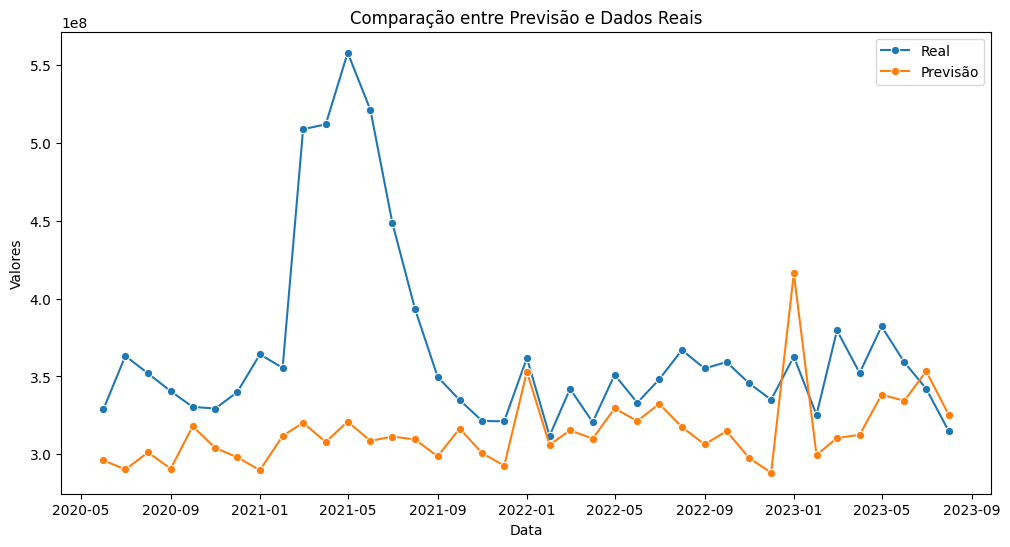

In [37]:
resultado = pred[['ds', 'yhat']].rename(columns={'ds': 'Data', 'yhat': 'Previsão'})
resultado['Real'] = dados_teste['y'].values

# Criando o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='Data', y='Real', data=resultado, label='Real', marker='o')
sns.lineplot(x='Data', y='Previsão', data=resultado, label='Previsão', marker='o')

plt.title('Comparação entre Previsão e Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

### **Modelo com AutoARIMA**

In [23]:
df_autoarima = dados_sp_transpostos

df_autoarima.head()

Região/Unidade da Federação,mes/ano,gastos_sp
0,2007-08-01,1665349.9
1,2007-09-01,4434168.64
2,2007-10-01,14577395.84
3,2007-11-01,35032259.98
4,2007-12-01,76668547.41


In [24]:
# Dividindo os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(df_autoarima) * 0.8)
train, test = df_autoarima.iloc[:train_size], df_autoarima.iloc[train_size:]

In [26]:
# Aplicando o modelo autoArima nos dados de treino
model = auto_arima(train['gastos_sp'], seasonal=True, m=12)
model.fit(train['gastos_sp'])

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [27]:
# Fazendo previsões nos dados de teste
future_periods = len(test)
forecast, conf_int = model.predict(n_periods=future_periods, return_conf_int=True)

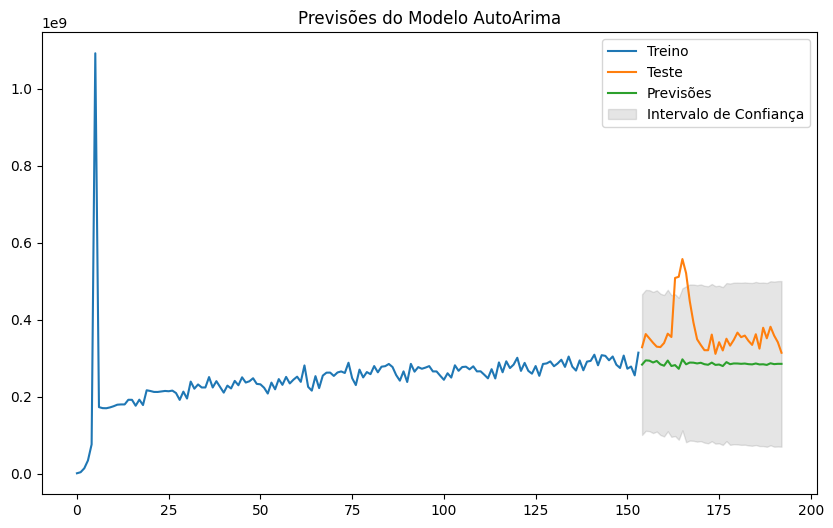

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['gastos_sp'], label='Treino')
plt.plot(test.index, test['gastos_sp'], label='Teste')
plt.plot(test.index, forecast, label='Previsões')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1, label='Intervalo de Confiança')
plt.legend()
plt.title('Previsões do Modelo AutoArima')
plt.show()

In [29]:
mae_autoarima = mean_absolute_error(test['gastos_sp'], forecast)
mse_autoarima = mean_squared_error(test['gastos_sp'], forecast)
r2_autoarima = r2_score(test['gastos_sp'], forecast)
mape_autoarima = mean_absolute_percentage_error(test['gastos_sp'], forecast)

print(f'MAE do AutoArima: {mae_autoarima}')
print(f'MSE do AutoArima: {mse_autoarima}')
print(f'R² do AutoArima: {r2_autoarima}')
print(f'MAPE do AutoArima: {mape_autoarima}')

MAE do AutoArima: 80938807.76334111
MSE do AutoArima: 1.0021378837176562e+16
R² do AutoArima: -1.8857287852579563
MAPE do AutoArima: 0.2047143129665933


### **Modelo com SeasonalNaive**

In [34]:
df_seasonalnaive = dados_sp_transpostos

df_seasonalnaive.head()

Região/Unidade da Federação,mes/ano,gastos_sp
0,2007-08-01,1665349.9
1,2007-09-01,4434168.64
2,2007-10-01,14577395.84
3,2007-11-01,35032259.98
4,2007-12-01,76668547.41


In [46]:
train_size = int(len(df_seasonalnaive) * 0.8)
train, test = df_seasonalnaive.iloc[:train_size], df_seasonalnaive.iloc[train_size:]

In [47]:
# Criando uma cópia do DataFrame de treino para aplicar o seasonalNaive
seasonal_naive_forecast = train.copy()

# Aplicando seasonalNaive para o período de teste
for i in range(len(test)):
    next_date = test.index[i]
    last_seasonal_date = train.index[-1]
    seasonal_naive_forecast.loc[next_date] = train.loc[last_seasonal_date]['gastos_sp']

In [48]:
# Ajustando o tamanho do seasonal_naive_forecast ao tamanho do conjunto de teste
seasonal_naive_forecast = seasonal_naive_forecast.loc[test.index]

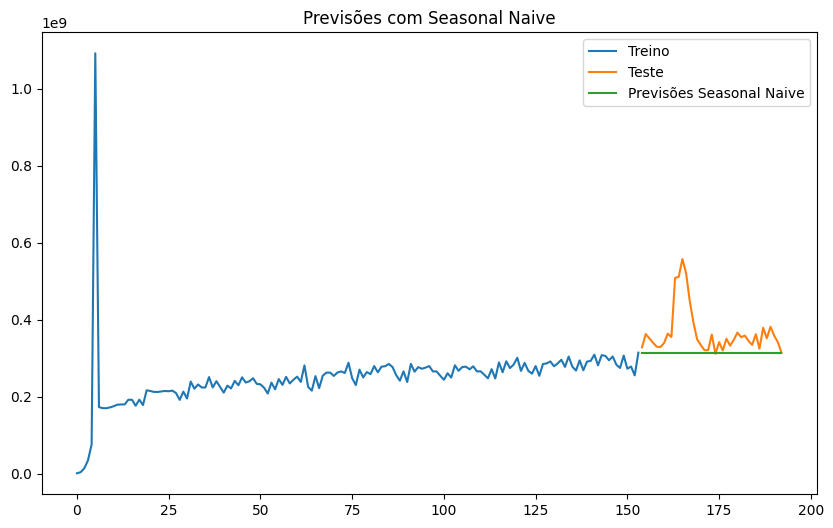

In [49]:
# Visualizando as previsões
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['gastos_sp'], label='Treino')
plt.plot(test.index, test['gastos_sp'], label='Teste')
plt.plot(seasonal_naive_forecast.index, seasonal_naive_forecast['gastos_sp'], label='Previsões Seasonal Naive')
plt.legend()
plt.title('Previsões com Seasonal Naive')
plt.show()

In [50]:
mae_seasonal_naive = mean_absolute_error(test['gastos_sp'], seasonal_naive_forecast['gastos_sp'])
mse_seasonal_naive = mean_squared_error(test['gastos_sp'], seasonal_naive_forecast['gastos_sp'])
r2_seasonal_naive = r2_score(test['gastos_sp'], seasonal_naive_forecast['gastos_sp'])
mape_seasonal_naive = mean_absolute_percentage_error(test['gastos_sp'], seasonal_naive_forecast['gastos_sp'])

print(f'MAE do Seasonal Naive: {mae_seasonal_naive}')
print(f'MSE do Seasonal Naive: {mse_seasonal_naive}')
print(f'R² do Seasonal Naive: {r2_seasonal_naive}')
print(f'MAPE do Seasonal Naive: {mape_seasonal_naive}')

MAE do Seasonal Naive: 52533354.55102564
MSE do Seasonal Naive: 6214891183554411.0
R² do Seasonal Naive: -0.789623032620703
MAPE do Seasonal Naive: 0.12577009552207633


### **Modelo com SeasonalWindowAverage**

In [51]:
df_seasonalwindowaverage = dados_sp_transpostos

df_seasonalwindowaverage.head()

Região/Unidade da Federação,mes/ano,gastos_sp
0,2007-08-01,1665349.9
1,2007-09-01,4434168.64
2,2007-10-01,14577395.84
3,2007-11-01,35032259.98
4,2007-12-01,76668547.41


In [52]:
train_size = int(len(df_seasonalwindowaverage) * 0.8)
train, test = df_seasonalwindowaverage.iloc[:train_size], df_seasonalwindowaverage.iloc[train_size:]

In [55]:
# Criando uma cópia do DataFrame de treino para aplicar o SeasonalWindowAverage
seasonal_window_average_forecast = train.copy()

# Aplicando SeasonalWindowAverage para o período de teste
for i in range(len(test)):
    next_date = test.index[i]
    last_seasonal_date = train.index[-1]
    last_seasonal_value = train.loc[last_seasonal_date]['gastos_sp']
    seasonal_window_average_forecast.loc[next_date] = last_seasonal_value

In [57]:
# Ajustando o tamanho das previsões para corresponder ao conjunto de teste
seasonal_window_average_forecast = seasonal_window_average_forecast.loc[test.index]

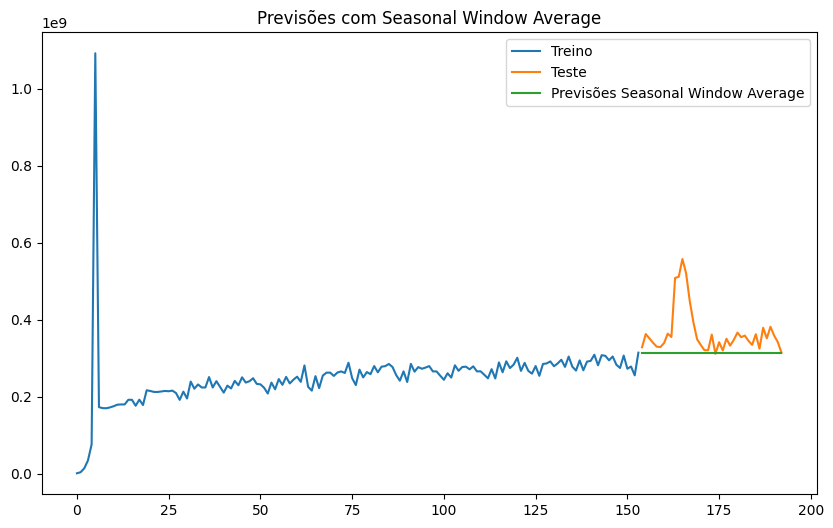

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['gastos_sp'], label='Treino')
plt.plot(test.index, test['gastos_sp'], label='Teste')
plt.plot(test.index, seasonal_window_average_forecast['gastos_sp'], label='Previsões Seasonal Window Average')
plt.legend()
plt.title('Previsões com Seasonal Window Average')
plt.show()

In [59]:
# Calculando as métricas MAE, MSE, R² e MAPE
mae_seasonal_window_average = mean_absolute_error(test['gastos_sp'], seasonal_window_average_forecast['gastos_sp'])
mse_seasonal_window_average = mean_squared_error(test['gastos_sp'], seasonal_window_average_forecast['gastos_sp'])
r2_seasonal_window_average = r2_score(test['gastos_sp'], seasonal_window_average_forecast['gastos_sp'])
mape_seasonal_window_average = mean_absolute_percentage_error(test['gastos_sp'], seasonal_window_average_forecast['gastos_sp'])

print(f'MAE do Seasonal Window Average: {mae_seasonal_window_average}')
print(f'MSE do Seasonal Window Average: {mse_seasonal_window_average}')
print(f'R² do Seasonal Window Average: {r2_seasonal_window_average}')
print(f'MAPE do Seasonal Window Average: {mape_seasonal_window_average}')

MAE do Seasonal Window Average: 52533354.55102564
MSE do Seasonal Window Average: 6214891183554411.0
R² do Seasonal Window Average: -0.789623032620703
MAPE do Seasonal Window Average: 0.12577009552207633


# **Conclusão**

Após a análise dos dados retornados com as métricas MSE, MAE, R² e MAPE, identificamos que os melhores resultados obtidos foram:

* 1º Seasonal Naive e Seasonal Window Average \\
* 2º Prophet \\
* 3º AutoARIMA

Mas existem alguns poréns durante a análise que gostaríamos de ressaltar:

* A análise não leva em consideração um evento especial, que foi a pandemia do covid-19. Sendo assim, os indicadores de MSE e MAE podem ter sofrido uma variação muito além do esperado, impactando em seus resultados. Como uma possível solução, podemos buscar bases de dados sobre a evolução de casos do COVID-19, verificar se há uma tendência forte de correlação do aumento de casos com o aumento de gastos e posteriormente, utilizar esta feature para ajudar a prever melhor estes casos.

* Não utilizamos hiperparâmetros em nenhum dos modelos, nem incluímos parâmetros personalizados mais aprofundados sobre cada um deles.

* Os modelos Seasonal Naive e Seasonal Window Average apresentaram dados muito semelhantes entre si, além de que o seu gráfico ficou com uma linha horizontal, indicando que a previsão dos dados está sendo contínua, o que na prática é algo que muito provavelmente não irá acontecer. Sendo assim, o modelo que melhor se adequou, com base em nossas expectativas nesta 1ª versão foi o modelo utilizando o **Prophet**.